In [40]:
library('RODBC')
library('quantmod')
library('PerformanceAnalytics')
source("/usr/common/config.R")
lcon <- odbcDriverConnect(sprintf("Driver={SQL Server};Server=%s;Database=%s;Uid=%s;Pwd=%s;", ldbserver, ldbname, ldbuser, ldbpassword), case = "nochange", believeNRows = TRUE)


In [41]:
getSubsequentRets<-function(schemeCode){
    newAdditions<-sqlQuery(lcon, sprintf("select SYMBOL, PORTFOLIO_DATE, INSTRUMENT_TYPE as ACTION from MF_PORTFOLIO_HISTORY 
                                            where SCHEME_CODE=%d 
                                            and (INSTRUMENT_TYPE like '%%addition%%'
                                            or INSTRUMENT_TYPE like '%%new%%')
                                            and INSTRUMENT = 'equity'
                                            order by PORTFOLIO_DATE", schemeCode))

    
    exits<-sqlQuery(lcon, sprintf("select SYMBOL, PORTFOLIO_DATE, INSTRUMENT_TYPE as ACTION from MF_PORTFOLIO_HISTORY 
                                            where SCHEME_CODE=%d 
                                            and INSTRUMENT_TYPE like '%%exit%%'
                                            and INSTRUMENT = 'equity'
                                            order by PORTFOLIO_DATE", schemeCode))
    
    if(length(newAdditions[,1]) > 0){
        newAdditions$ACTION<-"ADD"
    }
    
    if(length(exits[,1]) > 0){
        exits$ACTION<-"REMOVE"
    }
    
    actions<-rbind(newAdditions, exits)
    
    subseqRets<-data.frame(CODE=0, ACTION="", SYMBOL="", PORTFOLIO_DATE="", R10=0.0, R20=0.0, R50=0.0, stringsAsFactors = F)
    
    if(length(actions[,1]) == 0){
        subseqRets<-subseqRets[-1,]
        return(subseqRets)
    }

    #assume that you have the data on the portfolio disclosure date

    for(i in 1:length(actions[,1])){
        sym<-toString(actions[i,1])
        stDate<-as.Date(actions[i,2])
        ret50<-sqlQuery(lcon, sprintf("select top 50 * from RETURN_SERIES_ALL 
                                        where symbol='%s' 
                                        and time_stamp > '%s'
                                        order by time_stamp", sym, stDate))

        if(is.na(ret50) || length(ret50) < 2 || length(ret50[,1]) < 50){
            #print(sprintf("Skipping: %s:%s", sym, stDate))
            next
        }

        retXts<-xts(ret50$DAILY_RETURN, as.Date(ret50$TIME_STAMP))
        c10<-Return.cumulative(head(retXts, 10))
        c20<-Return.cumulative(head(retXts, 20))
        c50<-Return.cumulative(head(retXts, 50))

        subseqRets<-rbind(subseqRets, c(schemeCode, toString(actions[i,3]), sym, toString(stDate), c10, c20, c50))
    }

    subseqRets<-subseqRets[-1,]
    subseqRets$R10<-as.numeric(subseqRets$R10)
    subseqRets$R20<-as.numeric(subseqRets$R20)
    subseqRets$R50<-as.numeric(subseqRets$R50)
    return(subseqRets)
}

In [42]:
portfolioDate<-as.Date(sqlQuery(lcon, "select max(PORTFOLIO_DATE) from MF_PORTFOLIO_HISTORY")[[1]])
equityPct<-sqlQuery(lcon, sprintf("select scheme_code CODE, sum(weightage) WT from MF_PORTFOLIO_HISTORY 
                                    where INSTRUMENT ='equity'
                                    and INSTRUMENT_TYPE = ''
                                    and PORTFOLIO_DATE='%s'
                                    group by scheme_code", portfolioDate))

equityPct<-equityPct[equityPct$WT > 90,]
equityPct$NAME<-NA
for(i in 1:length(equityPct[,1])){
    equityPct$NAME[i]<-toString(sqlQuery(lcon, sprintf("select top 1 scheme_name from MF_NAV_HISTORY
                                                where scheme_code=%d
                                                order by auto_id desc", equityPct$CODE[i]))[1,1])
}

equityPct$NAME<-tolower(equityPct$NAME)
equityPct<-equityPct[grepl('direct', equityPct$NAME) 
                      & grepl('growth', equityPct$NAME) 
                      & !grepl('bonus', equityPct$NAME) 
                      & !grepl('index', equityPct$NAME),]

print(sprintf("no. of selected schemes: %d", length(equityPct[,1])))

[1] "no. of selected schemes: 260"


In [43]:
rets<-c()
for(i in 1:length(equityPct[,1])){
    scode<-as.numeric(equityPct$CODE[i])
    rets2<-getSubsequentRets(scode)
    #cat(sprintf("%d:%d;", scode, length(rets2[,1])))
    rets<-rbind(rets,rets2)
}

Warning message:
“closing unused RODBC handle 6”Warning message:
“closing unused RODBC handle 5”

In [44]:
addMedian10<-median(rets[rets$ACTION=='ADD', ]$R10)
addMedian20<-median(rets[rets$ACTION=='ADD', ]$R20)
addMedian50<-median(rets[rets$ACTION=='ADD', ]$R50)

remMedian10<-median(rets[rets$ACTION=='REMOVE', ]$R10)
remMedian20<-median(rets[rets$ACTION=='REMOVE', ]$R20)
remMedian50<-median(rets[rets$ACTION=='REMOVE', ]$R50)

print(sprintf("ADD: %.2f%%; %.2f%%; %.2f%%", 100*addMedian10, 100*addMedian20, 100*addMedian50))
print(sprintf("REM: %.2f%%; %.2f%%; %.2f%%", 100*remMedian10, 100*remMedian20, 100*remMedian50))

[1] "ADD: 0.49%; 1.81%; 4.88%"
[1] "REM: -0.01%; 0.90%; 3.27%"


[1] "outliers: "
        CODE ACTION    SYMBOL PORTFOLIO_DATE      R10      R20      R50
665   120381    ADD     QUESS     2016-06-30 21.08601 106.2884 98.31767
28122 120578    ADD     QUESS     2016-06-30 21.08601 106.2884 98.31767
81140 118632    ADD     QUESS     2016-06-30 21.08601 106.2884 98.31767
11875 119566    ADD THYROCARE     2016-04-30 12.42015  17.8251 15.79925
60176 118935    ADD     QUESS     2016-06-30 21.08601 106.2884 98.31767
91011 119646    ADD     QUESS     2016-06-30 21.08601 106.2884 98.31767
84166 119589    ADD THYROCARE     2016-04-30 12.42015  17.8251 15.79925


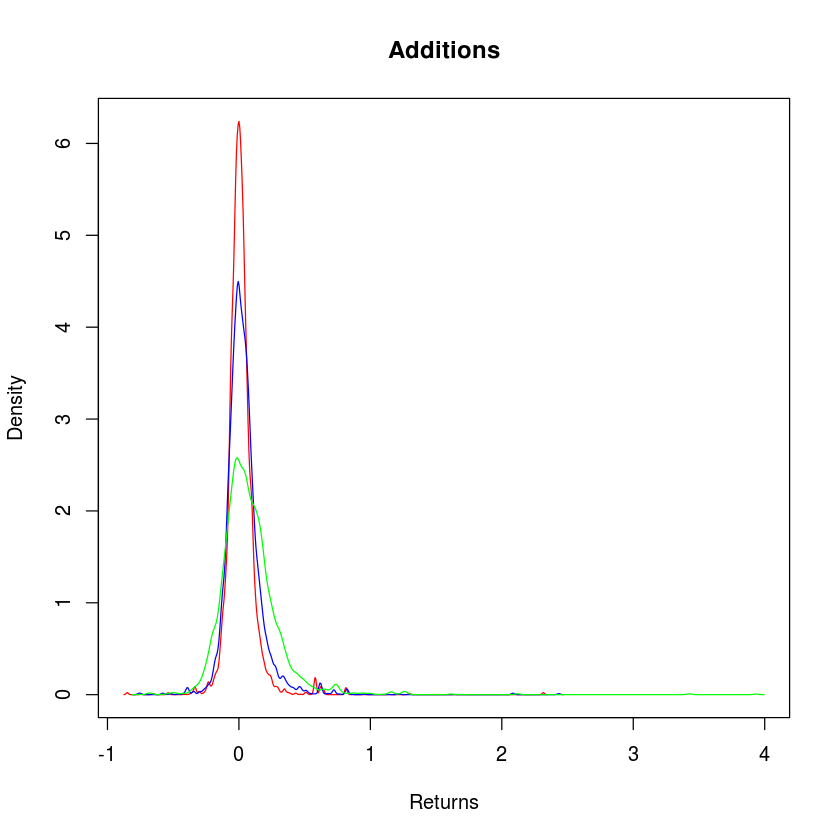

In [49]:
print("outliers: ")
print(rets[rets$ACTION=='ADD' & (rets$R10 >= 10 | rets$R20 >= 10 | rets$R50 >= 10), ])

den10<-density(rets[rets$ACTION=='ADD' & rets$R10 < 10, ]$R10)
den20<-density(rets[rets$ACTION=='ADD' & rets$R20 < 10, ]$R20)
den50<-density(rets[rets$ACTION=='ADD' & rets$R50 < 10, ]$R50)

plot(range(den10$x, den20$x, den50$x), range(den10$y, den20$y, den50$y), type = "n", ylab = "Density", xlab="Returns", 
     main="Additions")

lines(den10, col='red')
lines(den20, col='blue')
lines(den50, col='green')

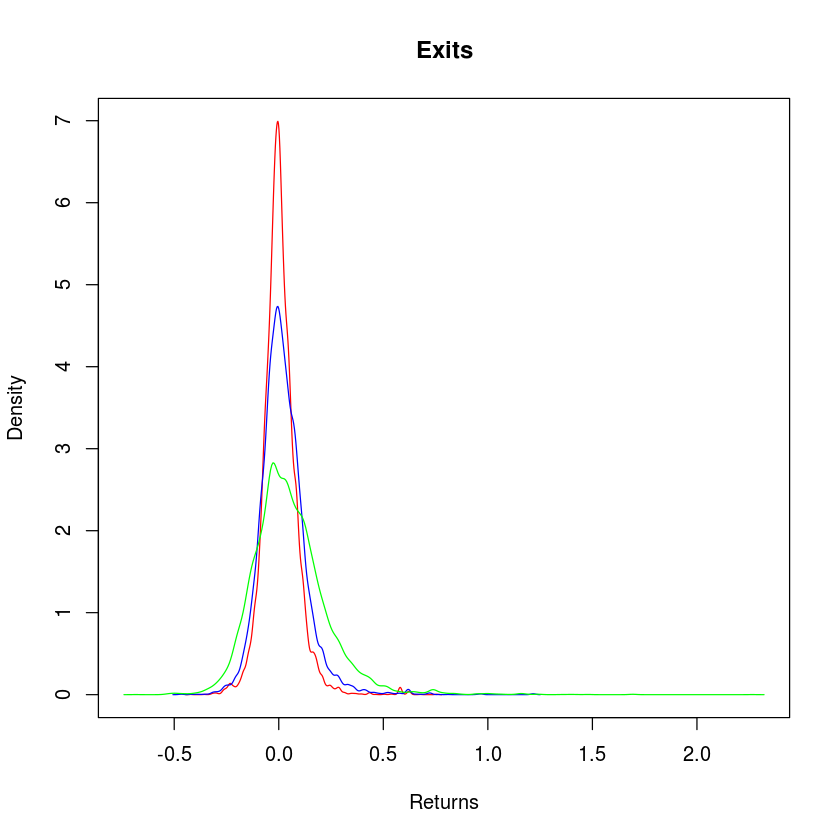

In [50]:
den10<-density(rets[rets$ACTION=='REMOVE' & rets$R10 < 10, ]$R10)
den20<-density(rets[rets$ACTION=='REMOVE' & rets$R20 < 10, ]$R20)
den50<-density(rets[rets$ACTION=='REMOVE' & rets$R50 < 10, ]$R50)

plot(range(den10$x, den20$x, den50$x), range(den10$y, den20$y, den50$y), type = "n", ylab = "Density", xlab="Returns", 
     main="Exits")

lines(den10, col='red')
lines(den20, col='blue')
lines(den50, col='green')